<a href="https://colab.research.google.com/github/langfordzd/burst_regimes/blob/main/walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neurodsp
!pip install bycycle
!pip install mne

In [2]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [3]:
#import shutil
#shutil.rmtree('/content/burst_regimes')

In [4]:
!git clone https://github.com/langfordzd/burst_regimes.git

Cloning into 'burst_regimes'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 58 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (58/58), 469.24 KiB | 2.44 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [5]:
import sys
sys.path.insert(0,'/content/bursts_regimes')
sys.path.append('/content/burst_regimes')


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config, sim, detectors
import itertools
from multiprocessing import Pool, cpu_count
import time
import pickle
from scipy.stats import lognorm
from scipy import ndimage
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12

In [7]:
r_seed = 0
t_num = 250
config.t_num = t_num
depth_point = (1, 50)
cycles = [2, 6]
shape = 0.6
loc = .03
scale = 0.001
distribution = ('lognorm', shape, loc, scale)
probs = [0.4, 0.6]
trials, chars = sim.simmer(r_seed,t_num,depth_point,cycles,distribution,probs)
config.trials = trials
print("Total number of bursts: " + str(len(chars)))

Total number of bursts: 401


# Data simulation
Above we simulate data that is in the same general data structure that the LFP and ECoG are in, which can be downloaded ****. The plots below show the amplitude distribution used to simulate the data, and plots a single trial with any generated bursts marked in yellow. The TFR is also shown as well as a >6 FOM thresholded representation. The amplitudes are specifically set high for illustrative purposes.

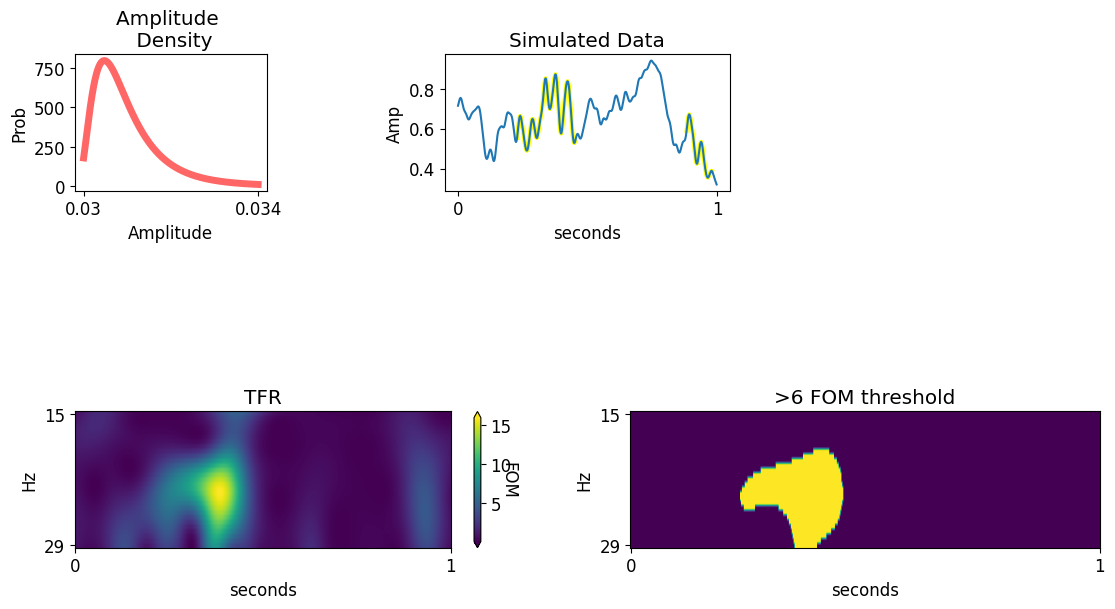

In [8]:
fig = plt.figure(1, figsize=(18, 18))
gs = gridspec.GridSpec(16, 16)
gs.update(wspace=12.5, hspace=0.9)
t = 0
xtr = fig.add_subplot(gs[0:2, 0:3])
dens = np.linspace(lognorm.ppf(0.01, shape,loc=loc,scale=scale),lognorm.ppf(0.99, shape,loc=loc,scale=scale), 1000)
xtr.plot(dens, lognorm.pdf(dens, shape,loc=loc,scale=scale),'r-', lw=5, alpha=0.6, label='amplitude density')
xtr.title.set_text('Amplitude \n Density')
xtr.set_xlabel('Amplitude')
xtr.set_ylabel('Prob')
xtr.set_xticks([np.min(dens), np.max(dens)])
xtr.set_xticklabels([np.around(np.min(dens),3), np.around(np.max(dens),3)])
xtr = fig.add_subplot(gs[0:2, 4:8])
data = trials[t][3][250:750]
times = np.arange(0,500)
xtr.plot(times,data)#trials[t][3][250:750])
for i,c in chars[chars['trial_number']==t].iterrows():
    xtr.plot(times[c['trial_start']-250:c['trial_end']-250],data[c['trial_start']-250:c['trial_end']-250], lw=3, c='yellow', zorder=-1)
xtr.title.set_text('Simulated Data')
xtr.set_xticks([0, 500])
xtr.set_xticklabels(['0', '1'])
xtr.set_xlabel('seconds')
xtr.set_ylabel('Amp')
xtr = fig.add_subplot(gs[4:6, 0:6])
tfr = trials[t][7][:,250:750]
tfr_o = xtr.imshow(tfr,aspect='auto')
cbar = fig.colorbar(tfr_o,ax=xtr, extend='both')
cbar.set_label('FOM', rotation=270)
xtr.title.set_text('TFR')
xtr.set_yticks([0, 28])
xtr.set_yticklabels(['15', '29'])
xtr.set_xticks([0, 500])
xtr.set_xticklabels(['0', '1'])
xtr.set_xlabel('seconds')
xtr.set_ylabel('Hz')
xtr = fig.add_subplot(gs[4:6, 6:12])
labeled_image, num_features = ndimage.label(tfr>6)
tfr_m = xtr.imshow(labeled_image,aspect='auto')
#cbar = fig.colorbar(tfr_m,ax=xtr, extend='both')
xtr.title.set_text('>6 FOM threshold')
xtr.set_yticks([0, 28])
xtr.set_yticklabels(['15', '29'])
xtr.set_xticks([0, 500])
xtr.set_xticklabels(['0', '1'])
xtr.set_xlabel('seconds')
xtr.set_ylabel('Hz')
plt.show()

# How did we pick the parameters for each method?

The BoP method is roughly based off of previous [research](https://elifesciences.org/articles/29086) in which the mouse data is taken. We simply used the same 6-median cutoff as they did in the paper, because it seemed to perform well there, and also fairly well in the simulation carried out in the supplementary material - though we did alter it and put a 2-cycle cutoff on the method we are carrying forward. Above we see that with the chose parameters  there are 1 actual bursts generated and 1 bursts that would be detected by the BoP method. The rest is simply about measuring the characteristics of the burst. The code below will then run the actual BoP method reported.

In [9]:
bop_recov = [detectors.pow_chars(*t) for t in trials]
config.bop_recov = pd.DataFrame(list(itertools.chain.from_iterable(bop_recov)),
                        columns=['loc','chan','ep','ids','start','end','duration'])

We tried to chose sets of parameter values for the BoC method that didn't give us false-bursts in 1/f noise as shown [here](https://github.com/langfordzd/burst_regimes/blob/main/parameter_picks.ipynb). These values are stored below in variable whichToEval, and can be related to the [cycle-by-cycle method](https://bycycle-tools.github.io/bycycle/index.html), which forms the basis for the BoC detection method.

In [10]:
with open("/content/burst_regimes/wte", "rb") as fp:
   whichToEval = pickle.load(fp)
print(whichToEval)
twos = [4,8,12,13,14,15,16]
threes = [0,1,2,3,5,6,7,9,10,11]
config.whichToEval = whichToEval
trial_index = np.arange(len(trials))
which_index = np.arange(len(whichToEval))
trial_eval_product = list(itertools.product(trial_index, which_index))

[(0.0, 0.2, 0.8, 0.2, 3.0), (0.0, 0.2, 0.8, 0.4, 3.0), (0.0, 0.2, 0.8, 0.6, 3.0), (0.0, 0.4, 0.6, 0.8, 3.0), (0.0, 0.4, 0.8, 0.8, 2.0), (0.0, 0.6, 0.2, 0.2, 3.0), (0.0, 0.6, 0.2, 0.4, 3.0), (0.0, 0.6, 0.2, 0.6, 3.0), (0.0, 0.6, 0.2, 0.8, 2.0), (0.0, 0.6, 0.4, 0.2, 3.0), (0.0, 0.6, 0.4, 0.4, 3.0), (0.0, 0.6, 0.4, 0.6, 3.0), (0.0, 0.6, 0.4, 0.8, 2.0), (0.0, 0.6, 0.6, 0.2, 2.0), (0.0, 0.6, 0.6, 0.4, 2.0), (0.0, 0.6, 0.6, 0.6, 2.0), (0.0, 0.6, 0.6, 0.8, 2.0)]


In [11]:
start_time = time.time()
num_cores = cpu_count()
pool = Pool(processes=num_cores)
cycler =  pool.starmap(detectors.cycler_worker, trial_eval_product)
pool.close()
pool.join()
print("--- %s minutes ---" % ((time.time() - start_time) / 60))

--- 2.506905937194824 minutes ---


In [12]:
res = list()
for c in cycler:
    res.append([c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7],len(c[8]),len(c[9]),len(c[10]),len(c[11])])
res_df = pd.DataFrame(res,columns=['loc', 'chan', 'ep', 'ids', 't', 'toE',
                               'stat', 'count',
                               'bocu','bocc','bopu','bopc'])#bocu is boc unique, bocc is common

evals = []
temp = res_df
res_df['has_b'] = res_df['count']>0
mean = res_df.groupby('toE').mean()
unis  = res_df.groupby('toE').sum()
cr = mean[['stat']]
unis  = unis[['bocu','bocc','bopu','bopc','count','has_b']]
unis['stat'] = cr['stat']
unis_twos = unis.iloc[twos]
unis_threes = unis.iloc[threes]
max2 = unis_twos['stat'].argmax()
max3 = unis_threes['stat'].argmax()
idx2 = unis_twos.index[max2]
idx3 = unis_threes.index[max3]
evals = [idx2,idx3]#.append([idx2,idx3])

<ipython-input-12-c70dbc47aa83>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean = res_df.groupby('toE').mean()
<ipython-input-12-c70dbc47aa83>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unis  = res_df.groupby('toE').sum()


In [13]:
indices2 = [i for i, x in enumerate(cycler) if x[5] == evals[0]]
indices3 = [i for i, x in enumerate(cycler) if x[5] == evals[1]]
temp2 = [cycler[index] for index in indices2]
temp3 = [cycler[index] for index in indices3]

boc_uniq = pd.concat([i[8] for i in temp2])
boc_comm = pd.concat([i[9] for i in temp2])
boc_uniq3 = pd.concat([i[8] for i in temp3])
boc_comm3 = pd.concat([i[9] for i in temp3])
boc_uniq['which'] = 'boc2'
boc_comm['which'] = 'co2'
boc_uniq3['which'] = 'boc3'
boc_comm3['which'] = 'co3'
bocs = pd.concat([boc_uniq,boc_comm,boc_uniq3,boc_comm3])
gb = bocs.groupby(['ids'])

boc_drop_overlaps = []
for name, g in gb:
    g = g.sort_values(by='end', ascending=False)
    g['overlap'] = g['end'].gt(g['start'].shift(fill_value=0))
    g['group'] = g['overlap'].eq(False).cumsum()
    g = g.drop_duplicates(subset='group').drop(columns=['overlap','group'])
    boc_drop_overlaps.append(g)

boc = pd.concat(boc_drop_overlaps)
##%% this is confusing because some are the same
bop_uniq2 = pd.concat([i[10] for i in temp2])
bop_uniq3 = pd.concat([i[10] for i in temp3])
bop_uniq = pd.concat([bop_uniq2,bop_uniq3]).drop_duplicates().reset_index(drop=True)
bop_comm2 = pd.concat([i[11] for i in temp2])
bop_comm3 = pd.concat([i[11] for i in temp3])
bop_comm = pd.concat([bop_comm2,bop_comm3]).drop_duplicates().reset_index(drop=True)
bop_uniq['which'] = 'bop'
bop_comm['which'] = 'bop_com'
bop = pd.concat([bop_uniq, bop_comm])
#you can have a common in bop with boc2 or boc3, so you have to drop all commons, based on boc2 or 3, not just one
bop.drop_duplicates(subset=['ids', 'start','end'], keep=False,inplace=True,ignore_index=True)
bop = bop[bop['which']=='bop']
com = pd.concat([boc, bop])
com['which'] = com['which'].replace(['boc2','boc3','bop','co2','co3','bop_com'],['boc','boc','bop','co','co','co'])

<ipython-input-13-a846709d040a>:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, g in gb:


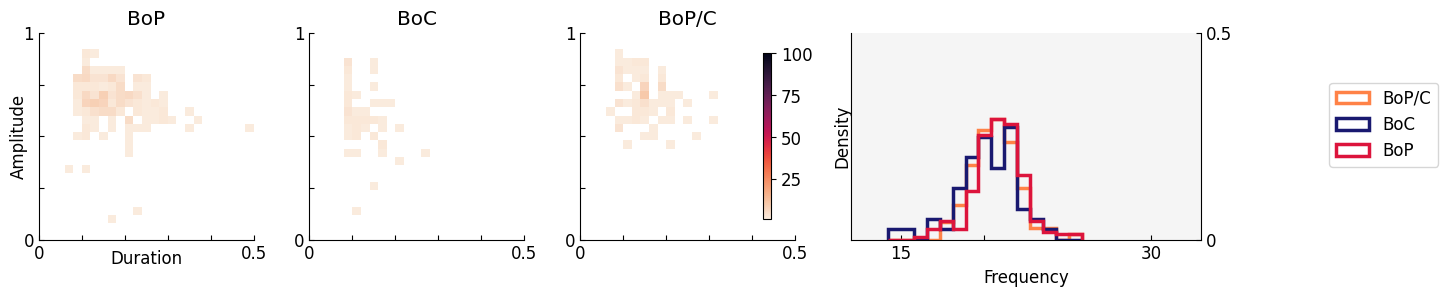

In [14]:
fig = plt.figure(1, figsize=(15, 15))
gs = gridspec.GridSpec(9, 9)
gs.update(wspace=0.7, hspace=0.9)
v_val = 100

xtr = fig.add_subplot(gs[0:2, 0:2])
sub = com[com['which']=='bop']
c = sns.color_palette("rocket_r", as_cmap=True)
xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1,vmin=1, vmax=v_val,
             range=[[0, 0.5], [0, 1]])
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(ylabel='Amplitude',xlabel='Duration')
xtr.set_title('BoP')
xtr.yaxis.set_label_coords(-0.05, 0.5)
xtr.xaxis.set_label_coords(0.5, -0.05)
###############################################################################
xtr = fig.add_subplot(gs[0:2, 2:4])
sub = com[com['which']=='boc']
p = xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1, vmin=1, vmax=v_val,
              range=[[0, 0.5], [0, 1]])
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(xlabel=None,ylabel=None)
xtr.set_title('BoC')
###############################################################################
xtr = fig.add_subplot(gs[0:2, 4:6])
sub = com[com['which']=='co']
p = xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1,vmin=1, vmax=v_val,
              range=[[0, 0.5], [0, 1]])
plt.colorbar(p[3],ax=xtr, shrink=0.8, pad = -0.15)
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(xlabel=None,ylabel=None)
xtr.set_title('BoP/C')

qs = ['#191970','#DC143C','#FF8247']
xtr = fig.add_subplot(gs[0:2, 6:9])
boc = com['freq'][com['which']=='boc']
bop = com['freq'][com['which']=='bop']
co = com['freq'][com['which']=='co']
xtr.hist([bop,boc,co], 15, histtype='step', stacked=False, fill=False,
            color=[qs[1],qs[0],qs[2]], density=True, label=['BoP','BoC','BoP/C'],
            linewidth=2.5)
xtr.legend(bbox_to_anchor=(1.7, 0.8))
xtr.set_ylim([0, 0.5])
xtr.set_xlim([12, 33])
xtr.spines['left'].set_visible(True)
xtr.spines['top'].set_visible(False)
xtr.yaxis.tick_right()
xtr.yaxis.set_label_position("right")
xtr.set_yticks([0, 0.5])
xtr.set_yticklabels(['0', '0.5'])
xtr.set_xticks([15, 20, 25, 30])
xtr.set_xticklabels(['15', '', '', '30'])
xtr.tick_params(axis="both",direction="in")
xtr.set(ylabel='Density',xlabel='Frequency')
xtr.yaxis.set_label_coords(-0.05, 0.5)
xtr.set_facecolor('whitesmoke')
plt.show()